In [124]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.io import decode_image
from torchvision.transforms import ToTensor, Lambda, v2

import matplotlib.pyplot as plt
import pandas as pd
from pandas._typing import Scalar
from pathlib import Path

## Step 0. Defining the Transforms

In [125]:
# Image Normalisation
transforms = v2.Compose([
    ToTensor(),
    Lambda(
        lambda x: torch.div(x, 255, out=x)
    )
])

# One Hot Encoding
target_transforms = Lambda(
    lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)
)

## Step 1. Load the Dataset from Remote

In [126]:
training_data = datasets.FashionMNIST(
    root="data",  # Local Path to store the downloaded data
    train=True,  # Downloading the train set
    download=True,  # Download if not exists locally
    transform=ToTensor(),  # Convert the elements of the dataset into tensors
)
print(training_data)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
print(testing_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Train Image
Shape: torch.Size([1, 28, 28])
Minimum: 0.0
Maximum: 1.0
Test Image
Shape: torch.Size([1, 28, 28])
Minimum: 0.0
Maximum: 1.0


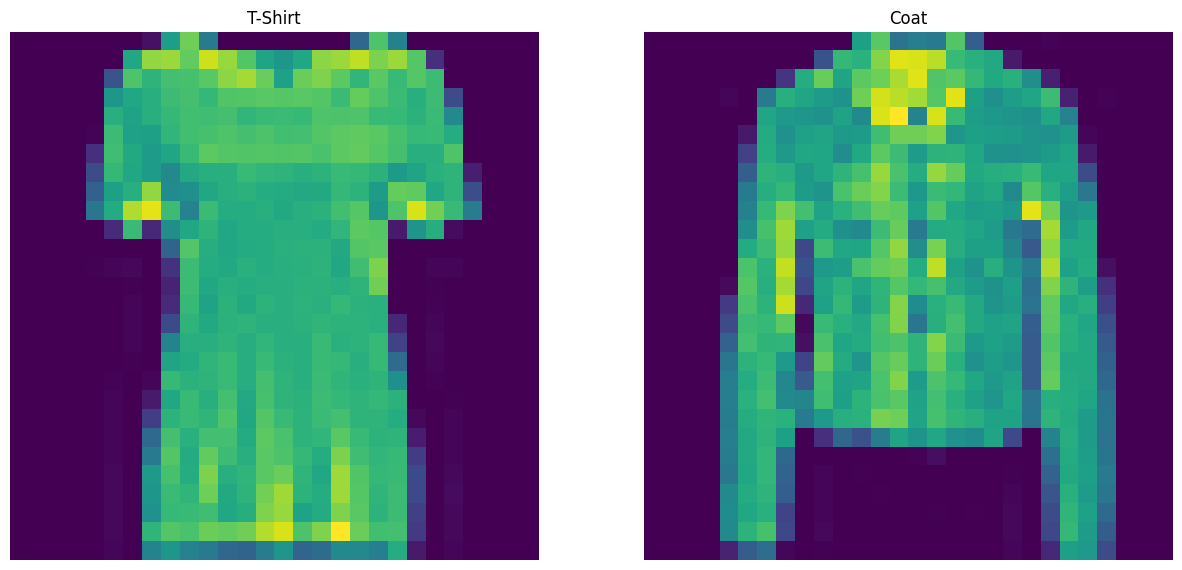

In [128]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Index from the sample
index = 10

# Images from the set
train_image, train_label = training_data[index]
print("Train Image")
print(f"Shape: {train_image.shape}\nMinimum: {torch.min(train_image)}\nMaximum: {torch.max(train_image)}")

test_image, test_label = testing_data[index]
print("Test Image")
print(f"Shape: {test_image.shape}\nMinimum: {torch.min(test_image)}\nMaximum: {torch.max(test_image)}")

# Canvas for the plots
fig = plt.figure(figsize=(15, 8))

fig.add_subplot(1, 2, 1)
plt.title(labels_map[train_label])
plt.imshow(train_image.squeeze())
plt.axis("off")

fig.add_subplot(1, 2, 2)
plt.title(labels_map[test_label])
plt.imshow(test_image.squeeze())
plt.axis("off")

plt.show()

## 1a. Visualising the Dataset

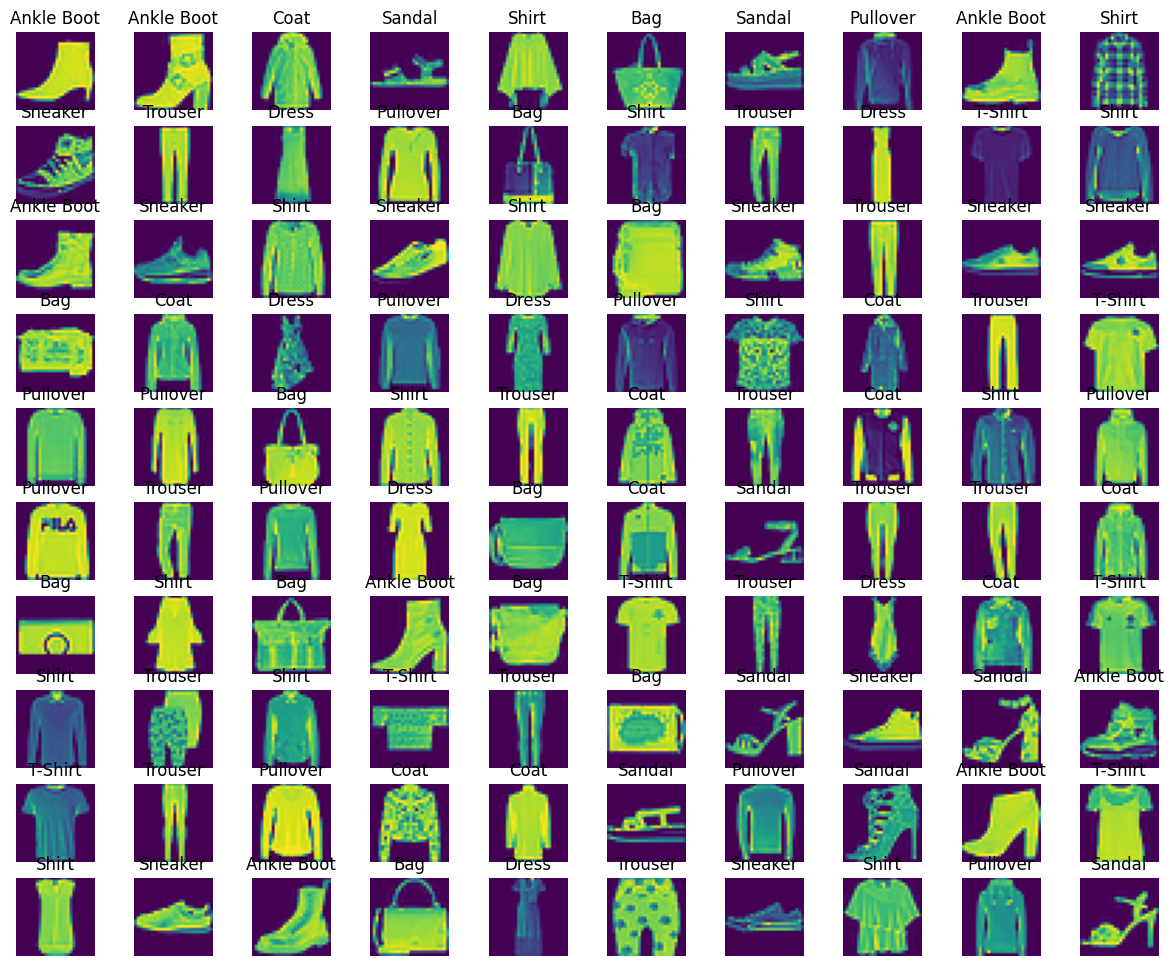

In [129]:
fig = plt.figure(figsize=(15, 12))
for i in range (10 * 10):
    sample_idx = int(torch.randint(len(training_data), size=(1,)))
    image_data, label = training_data[sample_idx]

    fig.add_subplot(10, 10, i + 1)
    plt.title(labels_map[label])
    plt.imshow(image_data.squeeze())
    plt.axis("off")

plt.show()

## Step 2. Creating the Custom Dataset

In [130]:
class FashionDataset(Dataset):
    """This class implements a Custom Dataset using the Pytorch Dataset Object."""
    def __init__(self, labels_file, images_dir, transforms=None, target_transforms=None) -> None:
        self.target_labels = pd.read_csv(labels_file)
        self.images_dir = images_dir
        self.transforms = transforms
        self.target_transforms = target_transforms

    def __len__(self) -> int:
        return len(self.target_labels)
    
    def __getitem__(self, index) -> tuple[torch.Tensor, Scalar]:
        image_path = Path(self.images_dir) / str(self.target_labels.iloc[index, 0])
        image = decode_image(str(image_path))
        image_label = self.target_labels.iloc[index, 1]
        return (image, image_label)

## Step 3. Applying DataLoaders
- DataLoaders in PyTorch are necessary as the Dataset object can load at most one sample of features and label at a time.
- DataLoaders provide a simple highly abstract API that supports: mini-batching, shuffling and other operations on the dataset alongwith multiprocessing to improve the efficiency of the pipeline.

In [131]:
batch_size = 64

train_dataloader = DataLoader(
    dataset=training_data, batch_size=batch_size, shuffle=True
)
test_dataloader = DataLoader(
    dataset=testing_data, batch_size=batch_size, shuffle=True
)

In [132]:
for i in range(2):
    feature_batch, label_batch = next(iter(train_dataloader))
    print(f"Feature Batch: {feature_batch.size()}")
    print(f"Label Batch: {label_batch.size()}")

Feature Batch: torch.Size([64, 1, 28, 28])
Label Batch: torch.Size([64])
Feature Batch: torch.Size([64, 1, 28, 28])
Label Batch: torch.Size([64])


## Step 4. Building the Network

In [137]:
class FashionNetwork(torch.nn.Module):
    """Implements a neural network to learn the FashionMNIST dataset."""
    def __init__(self) -> None:

        # Parent Constructor
        super().__init__()
        
        # Convolution and Pooling Layers
        self.sequential_stack_conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3)
        )

        # Dense Layers
        self.flatten = torch.nn.Flatten()
        self.sequential_stack_dense = torch.nn.Sequential(
            torch.nn.Linear(3 * 3 * 128, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 10),
        )
        
    def forward(self, X) -> torch.Tensor:
        """Forward propagation of all the modules in the network."""

        x = self.sequential_stack_conv(X)
        x = self.flatten(x)
        logits = self.sequential_stack_dense(x)

        return logits
    

# Model Instance
fashion_net = FashionNetwork().to(
    device=torch.accelerator.current_accelerator()
)
print(fashion_net)


FashionNetwork(
  (sequential_stack_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential_stack_dense): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


**Viewing the Model Parameters**

In [138]:
for name, parameters in fashion_net.named_parameters():
    print(f"Layer Name: {name}\n\nLayer Size: {parameters.size()}\n\nValues: {parameters[:2]}\n\n", end="---------------------------")

Layer Name: sequential_stack_conv.0.weight

Layer Size: torch.Size([32, 1, 3, 3])

Values: tensor([[[[ 0.1284, -0.2417, -0.2707],
          [ 0.3101, -0.1423, -0.1555],
          [ 0.2118, -0.3046, -0.2376]]],


        [[[-0.2723, -0.1532, -0.1451],
          [ 0.1960,  0.0030,  0.3177],
          [ 0.1726,  0.2239, -0.0874]]]], device='mps:0',
       grad_fn=<SliceBackward0>)

---------------------------Layer Name: sequential_stack_conv.0.bias

Layer Size: torch.Size([32])

Values: tensor([0.2500, 0.2649], device='mps:0', grad_fn=<SliceBackward0>)

---------------------------Layer Name: sequential_stack_conv.2.weight

Layer Size: torch.Size([64, 32, 3, 3])

Values: tensor([[[[ 0.0026, -0.0414,  0.0096],
          [ 0.0261, -0.0240,  0.0541],
          [-0.0282, -0.0360, -0.0336]],

         [[-0.0178,  0.0477, -0.0429],
          [ 0.0458,  0.0154, -0.0117],
          [-0.0458, -0.0144,  0.0457]],

         [[ 0.0195,  0.0272, -0.0469],
          [ 0.0450, -0.0060,  0.0371],
        

In [139]:
for name, module in fashion_net.named_modules():
    print(f"Layer Name -> {name}\n\n---------------\n\n{module}", end="\n---------------\n\n")

Layer Name -> 

---------------

FashionNetwork(
  (sequential_stack_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential_stack_dense): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)
---------------

Layer Name -> sequential_stack_conv

---------------

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stri

## Step 5. Training Loop

In [140]:
def train_loop(dataloader, model: torch.nn.Module, loss_fn, optimizer: torch.optim.Optimizer, device):
    """Implements the optimisation loop for training."""

    # Complete size of the dataset
    size = len(dataloader.dataset)

    # Setting the model in training mode
    model.train()

    # Training Loop
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward Pass
        logits = model(X)
        loss = loss_fn(logits, y)

        # Backward Pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"Loss: {loss:>7f} [{current:>5d} / {size:>d}]")


# Initiating the Training
learning_rate = 1e-4
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fashion_net.parameters(), lr=learning_rate)
device = torch.accelerator.current_accelerator()
epochs = 30
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}\n ----------------------------------------------")
    train_loop(train_dataloader, fashion_net, loss_fn, optimizer, device)

print("Done!!!!")

Epoch: 1
 ----------------------------------------------
Loss: 2.305918 [   64 / 60000]
Loss: 0.914097 [ 6464 / 60000]
Loss: 0.769516 [12864 / 60000]
Loss: 0.638868 [19264 / 60000]
Loss: 0.916247 [25664 / 60000]
Loss: 0.533002 [32064 / 60000]
Loss: 0.793869 [38464 / 60000]
Loss: 0.572440 [44864 / 60000]
Loss: 0.544801 [51264 / 60000]
Loss: 0.482600 [57664 / 60000]
Epoch: 2
 ----------------------------------------------
Loss: 0.747133 [   64 / 60000]
Loss: 0.625415 [ 6464 / 60000]
Loss: 0.687199 [12864 / 60000]
Loss: 0.557095 [19264 / 60000]
Loss: 0.673972 [25664 / 60000]
Loss: 0.577981 [32064 / 60000]
Loss: 0.618241 [38464 / 60000]
Loss: 0.700067 [44864 / 60000]
Loss: 0.520284 [51264 / 60000]
Loss: 0.469777 [57664 / 60000]
Epoch: 3
 ----------------------------------------------
Loss: 0.660154 [   64 / 60000]
Loss: 0.518402 [ 6464 / 60000]
Loss: 0.472072 [12864 / 60000]
Loss: 0.408600 [19264 / 60000]
Loss: 0.451230 [25664 / 60000]
Loss: 0.510022 [32064 / 60000]
Loss: 0.388983 [38464 /

## Step 6. Testing Loop

In [ ]:
def test_loop(dataloader, model: torch.nn.Module, loss_fn, device):
    """Implements the validation loop for model testing."""
    
    # Size of the dataset
    size = len(dataloader.dataset)

    # No of batches
    num_batches = len(dataloader)

    # Setting the model to evaluation mode
    model.eval()

    # Stopping auto grad from optimising to the test set
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

    # Test Metrics
    test_loss /= num_batches
    correct /= size
    print(f"Testing Analysis:\n - Accuracy: {100 * correct}%\n - Avg Loss: {test_loss:8f}\n")


test_loop(test_dataloader, fashion_net, loss_fn, device)


Test Error:
 - Accuracy: 90.45%
 - Avg Loss: 0.334231



## Random Inference

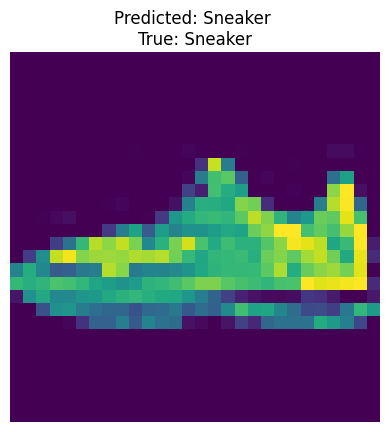

In [164]:
# Random Index
index = 973

image, label = testing_data[index]
image_plt = torch.clone(image)
image = image.unsqueeze(0).to(device)
logits = fashion_net(image)
class_prob = torch.nn.Softmax(dim=1)(logits)
pred_label = labels_map[class_prob.argmax(1).item()]
true_label = labels_map[label]

plt.title(f"Predicted: {pred_label} \nTrue: {true_label}")
plt.axis("off")
plt.imshow(image_plt.squeeze())
plt.show()

## Step 7. Saving the Model
- In PyTorch models can be saved in two ways:
    - By Entire Structure
    - By weights


In [161]:
model_store = Path("./models").mkdir(exist_ok=True)

# Saving the model by weights donly
torch.save(fashion_net.state_dict(), "fashion_net_weights.pth")

# Saving the entire model
torch.save(fashion_net, "fashion_net.pth")

## Loading the Model and Weights for Inference

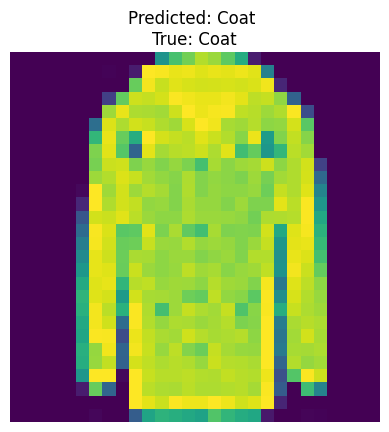

In [171]:
new_fashion_net = FashionNetwork().to(device)
new_fashion_net.load_state_dict(torch.load("./models/fashion_net_weights.pth", weights_only=True))

# Random Index
index = 762

image, label = testing_data[index]
image_plt = torch.clone(image)
image = image.unsqueeze(0).to(device)
logits = new_fashion_net(image)
class_prob = torch.nn.Softmax(dim=1)(logits)
pred_label = labels_map[class_prob.argmax(1).item()]
true_label = labels_map[label]

plt.title(f"Predicted: {pred_label} \nTrue: {true_label}")
plt.axis("off")
plt.imshow(image_plt.squeeze())
plt.show()

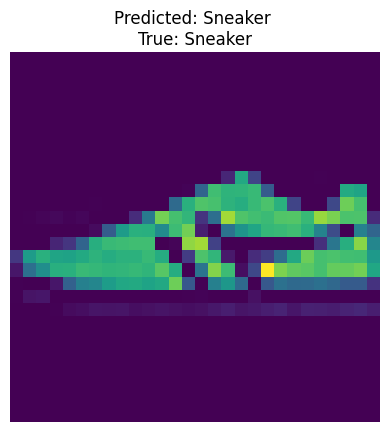

In [174]:
# Reloading the saved model
reloaded_fashion_net = torch.load("./models/fashion_net.pth", weights_only=False).to(device)

# Random Index
index = 752

image, label = testing_data[index]
image_plt = torch.clone(image)
image = image.unsqueeze(0).to(device)
logits = reloaded_fashion_net(image)
class_prob = torch.nn.Softmax(dim=1)(logits)
pred_label = labels_map[class_prob.argmax(1).item()]
true_label = labels_map[label]

plt.title(f"Predicted: {pred_label} \nTrue: {true_label}")
plt.axis("off")
plt.imshow(image_plt.squeeze())
plt.show()